<a href="https://colab.research.google.com/github/willy-wagtail/Notes/blob/master/03_pytorch_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from timeit import default_timer as timer 

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118


# Data Loading

In [40]:
train_data = datasets.FashionMNIST(
    root="data",          # where to download data to?
    train=True,           # training data or test data
    download=True,        # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels
)

In [41]:
test_data = datasets.FashionMNIST(
    root='data',
    train=False, # test data
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [42]:
image, label = train_data[0]
image.shape, label

# [color_channels=1, height=28, width=28]
# color_channel=1 means grayscale

(torch.Size([1, 28, 28]), 9)

In [43]:
# how many samples
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [44]:
# what are the classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

# Visualisation

Image shape: torch.Size([1, 28, 28])


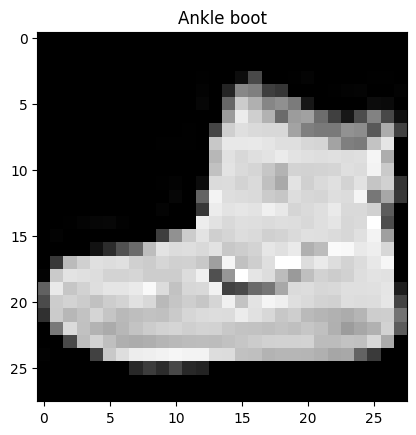

In [45]:
print(f"Image shape: {image.shape}")

# Shape [1, 28, 28] (colour channels, height, width) squeezed to [28, 28]
plt.imshow(image.squeeze(), cmap="gray") 
plt.title(class_names[label]);

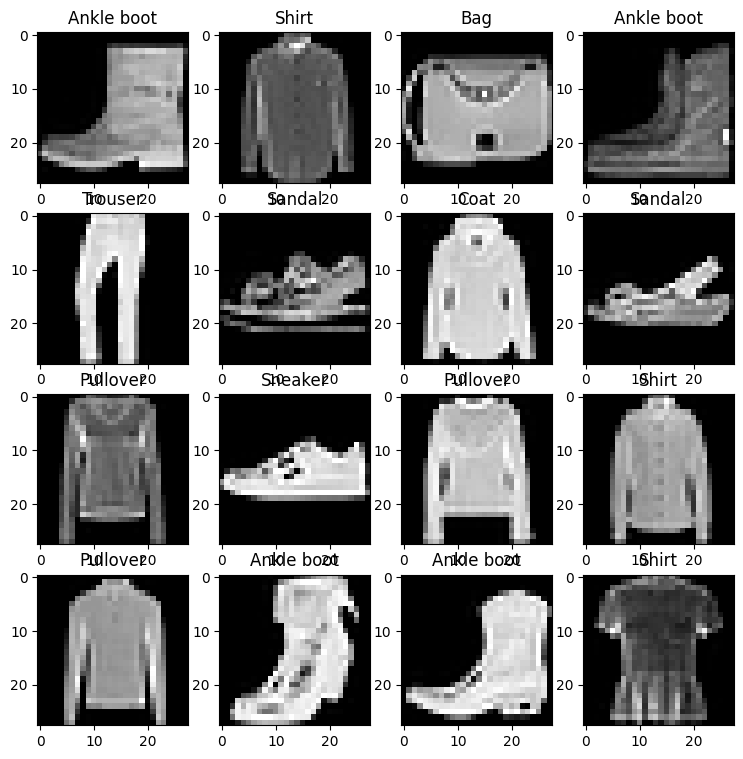

In [74]:
torch.manual_seed(42)

fig = plt.figure(figsize=(9,9))
rows, cols = 4,4

for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[random_idx]

  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(class_names[label])
  # plt.axis(False); # TypeError: 'bool' object is not callable


# Loading data into Model

In [68]:
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(
    train_data,            # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True           # shuffle data every epoch?
)

test_dataloader = DataLoader(
    test_data,
    shuffle=False # Don't necessarily have to shuffle test data
)

In [69]:
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fa3a0cec730>, <torch.utils.data.dataloader.DataLoader object at 0x7fa3a271dcc0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 10000 batches of 32


In [71]:
# sneak peak inside train_dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch

(torch.Size([32, 1, 28, 28]),
 tensor([5, 4, 8, 7, 4, 7, 7, 3, 7, 1, 1, 4, 9, 4, 8, 2, 6, 2, 8, 9, 7, 3, 4, 5,
         7, 4, 8, 1, 6, 9, 9, 4]))

Image size: torch.Size([1, 28, 28])
Label: 7, label size: torch.Size([])


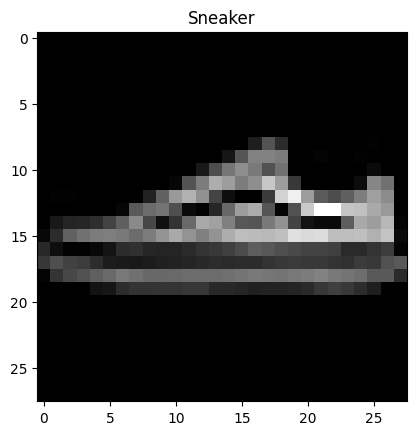

In [81]:
torch.manual_seed(42)

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
# plt.axis(False); 

print(f"Image size: {image.shape}")
print(f"Label: {label}, label size: {label.shape}")

# Model V0 - Linear

In [86]:
# Flatten an image sample using a nn model to create a feature vector
# [color_channels, height, width] -> [color_channels, height*width]

flatten_model = nn.Flatten()

x = train_features_batch[0]
output = flatten_model(x) # can do forward pass

x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [90]:
class FashionMNISTModelV0(nn.Module):
  def __init__(
      self, input_shape: int,
      hidden_units: int,
      output_shape: int
    ):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Flatten(),  # create feature vector
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.layers(x)

In [93]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=784, # size of flattened feature vector
    hidden_units=10,
    output_shape=len(class_names)
)

# as an experiement, train on cpu then compare training time with gpu
model_0.to('cpu') 

FashionMNISTModelV0(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [94]:
# Setup loss and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [97]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time